In [66]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib .pyplot as plt
from itertools import permutations, combinations
import os
import random
import scipy.stats as stats
import pickle
import torch.nn.functional as F
import math
import torch
from sklearn.model_selection import train_test_split

def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img


mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]
paras_more = [[6.5], 
              [ 0.35],
              [0.35],
              [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2 , 1.1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
              [(9,9)], [0.35], [(6,6), (7,7)]]
datasets = ['MNIST', 'Caltech256', 'VOC', 'COCO']
models = {'MNIST': [ 'ResNet18'],
          'Caltech256': ['DenseNet121'],
          'VOC': ['MSRN'],
          'COCO': ['MLD']}
model_names = ['MNIST_AlexNet_9938', 'MNIST_ResNet18_9906','Caltech256_DenseNet121_6838', 'Caltech256_Inception_v3_6720',
               'VOC_MSRN', 'VOC_MCAR', 'COCO_MLD', 'COCO_ASL']

def get_model_name(dataset, model):
    for i in range(len(model_names)):
        if dataset+'_'+model in model_names[i]:
            return model_names[i]

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, []
    
class CustomDatasetSingleMR(torch.utils.data.Dataset):
    def __init__(self, dataset, mr, para, transform=None):
        self.transform = transform
        self.data = []
        for idx, (img, label) in enumerate(dataset):
            img = mr(img, para)
            self.data.append(img)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, []

coco_info =  {
    "data_name": "coco",
    "data": os.path.join("data", "COCO"),
    "annotation_file": os.path.join("data", "COCO", 'annotations', 'image_info_test2014.json'),
    "phase": "test",
    "num_classes": 80
}


def load_testset(dataset_name, transform = None):
	if dataset_name == 'MNIST':
		dataset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
	elif dataset_name == 'Caltech256':
		caltech256_dataset = torchvision.datasets.Caltech256(root='data', download=True)
		X = [caltech256_dataset[i][0] for i in range(len(caltech256_dataset))]
		y = [caltech256_dataset[i][1] for i in range(len(caltech256_dataset))]
		_, X_test, _, y_test = train_test_split(X, y, test_size=0.1, random_state=18, stratify=y)
		dataset = CustomDataset(list(zip(X_test, y_test)), transform=transform)
	elif dataset_name == 'VOC':
		dataset = torchvision.datasets.VOCDetection('data/VOC', year="2007", image_set='test', transform=transform)
	else: #'COCO'
		dataset = torchvision.datasets.CocoDetection(os.path.join(coco_info['data'],'{}2014'.format(coco_info['phase'])), 
			annFile=coco_info['annotation_file'], transform=transform)
	#print(dataset_name, type(dataset), len(dataset))
	return dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def cosine_similarity(vec1, vec2):
    vec1, vec2 = vec1.to(device), vec2.to(device)
    dot_product = torch.dot(vec1, vec2)
    norm1 = torch.norm(vec1)
    norm2 = torch.norm(vec2)
    r = dot_product / (norm1 * norm2)
    return r.cpu().item()

In [41]:
datasets = ['Caltech256']
batch_size = 512

transform_predict = transforms.Compose([
	transforms.Resize(256),
	transforms.CenterCrop(224),
	transforms.Grayscale(num_output_channels=3), # the mode of some images is L not RGB
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def collate_fn_empty_labels(batch):
    images = torch.stack([item[0] for item in batch])
    labels = [[] for _ in batch]
    return images, labels

transform_vgg16 = transforms.Compose([
        transforms.Resize((224, 224)),  # VGG16需要224x224输入
        transforms.Grayscale(num_output_channels=3),  # 单通道转RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet统计量
    ])

transform_resnet = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
])


In [53]:
# calculate the distance of k-CMRs for (k from 1 to 5) through Resnet50

for dataset in datasets:
	for model in models[dataset]:
		
		# validity
		validity_filename = f'results/SelfOracle/{dataset}_validity.npy'
		validity = np.load(validity_filename, allow_pickle=True).item()
		filename_threshold = f'results/SelfOracle/{dataset}_threshold.txt'
		with open(filename_threshold) as f:
			lines = f.readlines()
			threshold = float(lines[1].split(':')[1].strip())

		weights = torchvision.models.ResNet50_Weights.DEFAULT
		resnet = torchvision.models.resnet50(weights=weights).to(device)
		resnet.eval()

		transform_resnet = transforms.Compose([
			transforms.Lambda(lambda x: x.convert('RGB') if hasattr(x, 'mode') and x.mode != 'RGB' else x),
			weights.transforms(),
		])

		# 移除最后的全连接层，仅保留卷积+池化部分
		feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

		#extract features of source images
		sourcetestset = load_testset(dataset, transform=transform_resnet)
		loader = torch.utils.data.DataLoader(sourcetestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
		features_source = []
		with torch.no_grad():
			for images, _ in loader:
				images = images.to(device)
				features = feature_extractor(images)
				features = features.view(features.size(0), -1)  # [batch, 512]
				features_source.append(features.cpu())  # 移回CPU节省显存
		features_source = torch.cat(features_source, dim=0)

		distance = [{} for _ in range(5)]

		test_dataset = load_testset(dataset)
		for k in range(4, 5):
			for cmr in permutations(range(len(mrs)), k+1):
				# vgg16 extract features of follow-up images
				followuptestset = CustomDataset(test_dataset, cmr=cmr, transform=transform_resnet)
				loader = torch.utils.data.DataLoader(followuptestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
				features_followup = []
				with torch.no_grad():
					for images, _ in loader:
						images = images.to(device)
						features = feature_extractor(images)
						features = features.view(features.size(0), -1)  # [batch, 512]
						features_followup.append(features.cpu())  # 移回CPU节省显存
					features_followup = torch.cat(features_followup, dim=0)

				num, eu_sum, cos_sum = 0, 0, 0
				for i in range(len(features_followup)):
					if validity[cmr][i] <= threshold:
						num += 1
						eu_sum +=  torch.sqrt(torch.sum((features_source[i] - features_followup[i]) ** 2)).cpu().item()
						cos_sum += cosine_similarity(features_source[i], features_followup[i])
				distance[k][cmr] = eu_sum / num
				print(cmr, round(distance[k][cmr],2), cos_sum/num)

		np.save(f"results/resnet50/cmr_{model}", np.array(distance))

Files already downloaded and verified
Files already downloaded and verified
(0, 1, 2, 3, 4) 5.72 0.8747163963391866
(0, 1, 2, 3, 5) 5.92 0.8671289987032105
(0, 1, 2, 3, 6) 4.76 0.9124159411408862
(0, 1, 2, 4, 3) 5.73 0.87445486442827


KeyboardInterrupt: 

In [ ]:
# calculate the distance of k-CMRs for (k from 1 to 5) through Vgg16

for dataset in datasets:
	for model in models[dataset]:
		
		# validity
		validity_filename = f'results/SelfOracle/{dataset}_validity.npy'
		validity = np.load(validity_filename, allow_pickle=True).item()
		filename_threshold = f'results/SelfOracle/{dataset}_threshold.txt'
		with open(filename_threshold) as f:
			lines = f.readlines()
			threshold = float(lines[1].split(':')[1].strip())

		weights = torchvision.models.VGG16_Weights.DEFAULT
		vgg = torchvision.models.vgg16(weights=weights).features.to(device)
		vgg.eval()

		#vgg16 extract features of source images
		sourcetestset = load_testset(dataset, transform=transform_vgg16)
		loader = torch.utils.data.DataLoader(sourcetestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
		features_source = []
		with torch.no_grad():
			for images, _ in loader:
				images = images.to(device)
				features = vgg(images)
				features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
				features = features.view(features.size(0), -1)  # [batch, 512]
				features_source.append(features.cpu())  # 移回CPU节省显存
		features_source = torch.cat(features_source, dim=0)

		distance = [{} for _ in range(5)]

		test_dataset = load_testset(dataset)
		for k in range(5):
			for cmr in permutations(range(len(mrs)), k+1):
				print(cmr)
				# vgg16 extract features of follow-up images
				followuptestset = CustomDataset(test_dataset, cmr=cmr, transform=transform_vgg16)
				loader = torch.utils.data.DataLoader(followuptestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
				features_followup = []
				with torch.no_grad():
					for images, _ in loader:
						images = images.to(device)
						features = vgg(images)
						features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
						features = features.view(features.size(0), -1)  # [batch, 512]
						features_followup.append(features.cpu())  # 移回CPU节省显存
					features_followup = torch.cat(features_followup, dim=0)

				num, eu_sum = 0, 0
				for i in range(len(features_followup)):
					if validity[cmr][i] <= threshold:
						num += 1
						eu_sum +=  torch.sqrt(torch.sum((features_source[i] - features_followup[i]) ** 2)).cpu().item()
						#cos_sum += cosine_similarity(features_source[i], features_followup[i])
				distance[k][cmr] = eu_sum / num

		np.save(f"results/vgg16/cmr_{model}", np.array(distance))

In [61]:
dataset = 'Caltech256'
model = 'DenseNet121'
model_name = get_model_name(dataset, model)
d = np.load(f"results/vgg16/cmr_{model}.npy", allow_pickle=True) 
print(sum(d[4].values())/ len(d[4]))


print(model_name)
with open(f'error_revealing/error_{model_name}.pkl', 'rb') as f:
    error = pickle.load(f)
fault = np.load(os.path.join('results', 'error_classification', dataset+'_'+model+'.npy'))

def get_fault(failure_list, fault):
    f = set()
    for failure in failure_list:
        if fault[failure] != -1:
            f.add(fault[failure])
    return f

fault_5_num =0
fault_5 = set()
cmr_5 = 0
fault_5_max = 0

for cmr in error:
    if len(cmr) < 5:
        continue
    cmr_5 += 1
    if len(get_fault(error[cmr], fault)) > fault_5_max:
        fault_5_max = len(get_fault(error[cmr], fault))
    fault_5.update(get_fault(error[cmr], fault))
    fault_5_num += len(get_fault(error[cmr], fault))
    
print(fault_5_num / cmr_5)
print(fault_5_max)
print(len(fault_5))


4.992199831228007
Caltech256_DenseNet121_6838
275.5696031746032
291
301


In [56]:
a = set()
a.update([1,3,2])
a.update([4,3,2])
print(a)

{1, 2, 3, 4}


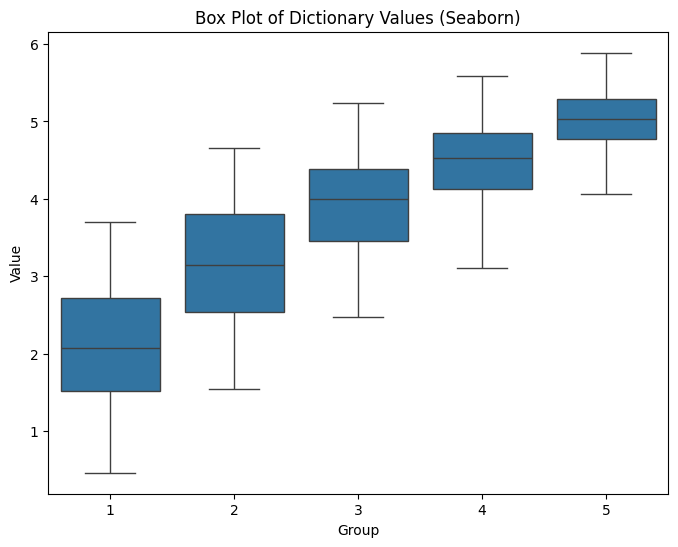

In [20]:
import seaborn as sns
import pandas as pd
data = d

# 将数据转换为长格式 DataFrame
df = pd.DataFrame({
    "Group": [i+1 for i in range(len(data)) for _ in data[i]],
    "Value": [v for d in data for v in d.values()]
})

# 绘制箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Group", y="Value")

# 添加标题
plt.title("Box Plot of Dictionary Values (Seaborn)")
plt.show()

In [64]:
def get_iou(set_a, set_b):
    """
    计算两个集合的Jaccard相似度（交集大小/并集大小）
    
    参数:
        set_a (set): 第一个集合
        set_b (set): 第二个集合
    
    返回:
        float: Jaccard相似度，范围[0,1]
    """
    # 计算交集和并集
    intersection = set_a & set_b  # 或使用 set_a.intersection(set_b)
    union = set_a | set_b         # 或使用 set_a.union(set_b)
    
    return len(intersection) / len(union)

In [67]:
# use vgg16

datasets = ['Caltech256']

for dataset in datasets:
	for model in models[dataset]:
		model_name = get_model_name(dataset, model)
		print(model_name)
		pred_source = np.load(f'predictions/{model_name}_source.npy')
		
		# validity
		validity_filename = f'results/increase_para/{dataset}.npy'
		validity = np.load(validity_filename, allow_pickle=True).item()
		filename_threshold = f'results/SelfOracle/{dataset}_threshold.txt'
		with open(filename_threshold) as f:
			lines = f.readlines()
			threshold = float(lines[1].split(':')[1].strip())

		# faults
		faults = np.load(os.path.join('results', 'error_classification', dataset+'_'+model+'.npy'))


		model = torchvision.models.densenet121(weights='DEFAULT')  
		num_classes = 257
		model.classifier = nn.Linear(model.classifier.in_features, num_classes)
		model.load_state_dict(torch.load('./models/'+model_name+'.pth'))
		model.to(device)
		model.eval()

		#vgg16 extract features of source images
		weights = torchvision.models.VGG16_Weights.DEFAULT
		vgg = torchvision.models.vgg16(weights=weights).features.to(device)
		vgg.eval()

		sourcetestset = load_testset(dataset, transform=transform_vgg16)
		loader = torch.utils.data.DataLoader(sourcetestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
		features_source = []
		with torch.no_grad():
			for images, _ in loader:
				images = images.to(device)
				features = vgg(images)
				features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
				features = features.view(features.size(0), -1)  # [batch, 512]
				features_source.append(features.cpu())  # 移回CPU节省显存
		features_source = torch.cat(features_source, dim=0)

		test_dataset = load_testset(dataset)
		for index, mr in enumerate(mrs):
			for para in  paras_more[index]:

				# predict
				dataset_followup = CustomDatasetSingleMR(test_dataset, mr=mr, para=para, transform=transform_predict)
				testload_followup = torch.utils.data.DataLoader(dataset_followup, batch_size=batch_size, shuffle=False)
				pred_followup = np.zeros(len(pred_source), dtype=int)
				with torch.no_grad():
					for i,(X,y) in enumerate(testload_followup):
						X = X.to(device)
						outputs = model(X)
						_, pred = torch.max(outputs, 1)
						pred_followup[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()

				# vgg16 extract features of follow-up images
				followuptestset = CustomDatasetSingleMR(test_dataset, mr=mr, para=para, transform=transform_vgg16)
				loader = torch.utils.data.DataLoader(followuptestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
				features_followup = []
				with torch.no_grad():
					for images, _ in loader:
						images = images.to(device)
						features = vgg(images)
						features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
						features = features.view(features.size(0), -1)  # [batch, 512]
						features_followup.append(features.cpu())  # 移回CPU节省显存
					features_followup = torch.cat(features_followup, dim=0)

				# calculate faults, the difference in embedding space
				fault_detected = set()
				num, eu_sum, cos_sum = 0, 0, 0
				valid_num= 0
				for i in range(len(pred_followup)):
					if validity[f'{mrs_name[index]}_{para}'][i] <= threshold:
						valid_num += 1
						if pred_source[i] != pred_followup[i] and faults[i] != -1:
							fault_detected.add(faults[i])
						num += 1
						eu_sum +=  torch.sqrt(torch.sum((features_source[i] - features_followup[i]) ** 2)).cpu().item()
						cos_sum += cosine_similarity(features_source[i], features_followup[i])
				iou = get_iou(fault_detected, fault_5)	

				print(f'{mrs_name[index]} {para}: Valid: {valid_num}\tFaults: {len(fault_detected)}\tIOU: {iou}\tEU: {round(eu_sum/num, 2)}\tCos: {round(cos_sum/num, 2)}')


Caltech256_DenseNet121_6838
Files already downloaded and verified
Files already downloaded and verified


KeyError: 'rotate_6.5'

In [50]:
# use resnet50

datasets = ['Caltech256']

# transform_resnet = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(256),
#     torchvision.transforms.CenterCrop(224),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
# ])

for dataset in datasets:
	for model in models[dataset]:
		model_name = get_model_name(dataset, model)
		print(model_name)
		pred_source = np.load(f'predictions/{model_name}_source.npy')
		
		# validity
		validity_filename = f'results/increase_para/{dataset}.npy'
		validity = np.load(validity_filename, allow_pickle=True).item()
		filename_threshold = f'results/SelfOracle/{dataset}_threshold.txt'
		with open(filename_threshold) as f:
			lines = f.readlines()
			threshold = float(lines[1].split(':')[1].strip())

		# faults
		faults = np.load(os.path.join('results', 'error_classification', dataset+'_'+model+'.npy'))

		model = torchvision.models.densenet121(weights='DEFAULT')  
		num_classes = 257
		model.classifier = nn.Linear(model.classifier.in_features, num_classes)
		model.load_state_dict(torch.load('./models/'+model_name+'.pth'))
		model.to(device)
		model.eval()


		# 使用 ResNet50 提取 source 图像特征
		weights = torchvision.models.ResNet50_Weights.DEFAULT
		transform_resnet = transforms.Compose([
			transforms.Lambda(lambda x: x.convert('RGB') if hasattr(x, 'mode') and x.mode != 'RGB' else x),
			weights.transforms(),
		])
		resnet = torchvision.models.resnet50(weights=weights).to(device)
		resnet.eval()
		# 移除最后的全连接层，仅保留卷积+池化部分
		feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])  # 去掉 fc 层

		sourcetestset = load_testset(dataset, transform=transform_resnet)
		loader = torch.utils.data.DataLoader(sourcetestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
		features_source = []
		with torch.no_grad():
			for images, _ in loader:
				images = images.to(device)
				features = feature_extractor(images)
				features = features.view(features.size(0), -1)  # [batch, 512]
				features_source.append(features.cpu())  # 移回CPU节省显存
		features_source = torch.cat(features_source, dim=0)

		test_dataset = load_testset(dataset)
		for index, mr in enumerate(mrs):
			for para in  paras_more[index]:

				# predict
				dataset_followup = CustomDatasetSingleMR(test_dataset, mr=mr, para=para, transform=transform_predict)
				testload_followup = torch.utils.data.DataLoader(dataset_followup, batch_size=batch_size, shuffle=False)
				pred_followup = np.zeros(len(pred_source), dtype=int)
				with torch.no_grad():
					for i,(X,y) in enumerate(testload_followup):
						X = X.to(device)
						outputs = model(X)
						_, pred = torch.max(outputs, 1)
						pred_followup[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()

				# vgg16 extract features of follow-up images
				followuptestset = CustomDatasetSingleMR(test_dataset, mr=mr, para=para, transform=transform_resnet)
				loader = torch.utils.data.DataLoader(followuptestset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=4)
				features_followup = []
				with torch.no_grad():
					for images, _ in loader:
						images = images.to(device)
						features = feature_extractor(images)
						features = features.view(features.size(0), -1)  # [batch, 512]
						features_followup.append(features.cpu())  # 移回CPU节省显存
					features_followup = torch.cat(features_followup, dim=0)

				# calculate faults, the difference in embedding space
				fault_detected = set()
				num, eu_sum, cos_sum = 0, 0, 0
				valid_num= 0
				for i in range(len(pred_followup)):
					if validity[f'{mrs_name[index]}_{para}'][i] <= threshold:
						valid_num += 1
						if pred_source[i] != pred_followup[i] and faults[i] != -1:
							fault_detected.add(faults[i])
						num += 1
						eu_sum +=  torch.sqrt(torch.sum((features_source[i] - features_followup[i]) ** 2)).cpu().item()
						cos_sum += cosine_similarity(features_source[i], features_followup[i])
						

				print(f'{mrs_name[index]} {para}: Valid: {valid_num}\tFaults: {len(fault_detected)}\tEU: {round(eu_sum/num, 2)}\tCos: {round(cos_sum/num, 2)}')


Caltech256_DenseNet121_6838
Files already downloaded and verified
Files already downloaded and verified
rotate 3: Valid: 3061	Faults: 186	EU: 4.17	Cos: 0.93
rotate 4: Valid: 3061	Faults: 198	EU: 4.65	Cos: 0.92
rotate 5: Valid: 3061	Faults: 207	EU: 5.03	Cos: 0.9
rotate 6: Valid: 3061	Faults: 221	EU: 5.38	Cos: 0.89
rotate 7: Valid: 3061	Faults: 231	EU: 5.68	Cos: 0.88
enh_bri 1.8: Valid: 3061	Faults: 280	EU: 5.36	Cos: 0.88
enh_bri 1.7: Valid: 3061	Faults: 272	EU: 4.97	Cos: 0.9
enh_bri 1.6: Valid: 3061	Faults: 253	EU: 4.54	Cos: 0.91
enh_bri 1.5: Valid: 3061	Faults: 244	EU: 4.07	Cos: 0.93
enh_bri 1.4: Valid: 3061	Faults: 223	EU: 3.53	Cos: 0.95
enh_bri 1.3: Valid: 3061	Faults: 193	EU: 2.92	Cos: 0.96
enh_bri 1.2: Valid: 3061	Faults: 163	EU: 2.19	Cos: 0.98
enh_bri 1.1: Valid: 3061	Faults: 109	EU: 1.32	Cos: 0.99
enh_bri 0.9: Valid: 3061	Faults: 89	EU: 0.99	Cos: 1.0
enh_bri 0.8: Valid: 3061	Faults: 131	EU: 1.58	Cos: 0.99
enh_bri 0.7: Valid: 3061	Faults: 166	EU: 2.11	Cos: 0.98
enh_bri 0.6: Valid:

In [ ]:
# calculate the distance between sources and follow-up with larger paras
def collate_fn_empty_labels(batch):
    images = torch.stack([item[0] for item in batch])
    labels = [[] for _ in batch]
    return images, labels

def extract_and_save_vgg16_features(datasetname, batch_size=256, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # VGG16需要224x224输入
        transforms.Grayscale(num_output_channels=3),  # 单通道转RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet统计量
    ])
    dataset = load_testset(datasetname, transform=transform)
    
    # 3. 加载VGG16模型(使用最新权重API)
    weights = torchvision.models.VGG16_Weights.DEFAULT
    model = torchvision.models.vgg16(weights=weights).features.to(device)
    model.eval()
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_empty_labels, num_workers=2)
    
    # 5. 特征提取
    all_features = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            features = model(images)
            features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)  # [batch, 512]
            all_features.append(features.cpu())  # 移回CPU节省显存
    # 6. 合并并保存特征
    all_features = torch.cat(all_features, dim=0)
    save_path = os.path.join('results', 'vgg16', f'{datasetname}.pt')
    torch.save(all_features, save_path)
    print(f"Features saved to {save_path} | Shape: {all_features.shape}")
    
for dataset in datasets:
    extract_and_save_vgg16_features(dataset)

In [ ]:
# use Vgg16 extract features and then calculate eu distance and cos similarity

# increase the parameter of MR for Caltech256
from torchmetrics.image import StructuralSimilarityIndexMeasure as ssim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1000

transform_predict = transforms.Compose([
	transforms.Resize(256),
	transforms.CenterCrop(224),
	transforms.Grayscale(num_output_channels=3), # the mode of some images is L not RGB
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_distance =  transforms.Compose([
	transforms.Resize((64, 64)),
	transforms.Grayscale(num_output_channels=3),
	transforms.ToTensor(),
])

def get_average_distance(mr, para, distance_total, ssim_total):
	distance_sum, ssim_sum, num = 0, 0, 0
	for i in range(len(distance_total)):
		if validity[f'{mr}_{para}'][i]<=threshold:
			distance_sum += distance_total[i]
			ssim_sum += ssim_total[i]
			num += 1
	return (distance_sum / num, ssim_sum / num) if num > 0 else (0, 0)

def get_fault_num(mr, para, pred_source, pred_followup):
	failure_index = []
	for i in range(len(pred_source)):
			if validity[f'{mr}_{para}'][i]<=threshold and pred_source[i] != pred_followup[i]:
				failure_index.append(i)
	category = set()
	for failure in failure_index:
		if error_category[failure] != -1:
			category.add(error_category[failure])
	return len(category)

error_category = np.load(os.path.join('results', 'error_classification', 'Caltech256'+'_'+'DenseNet121'+'.npy'))

model_name = 'Caltech256_DenseNet121_6838'
model = torchvision.models.densenet121(weights='DEFAULT')  
num_classes = 257
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load('./models/'+model_name+'.pth'))
model.to(device)
model.eval()

def calculate_euclidean(imgs1, imgs2):
    return torch.norm(imgs1 - imgs2, p=2, dim=(1, 2, 3)).cpu().tolist()

def calculate_ssim(imgs1, imgs2):
      ssim_calculator = ssim(data_range=1.0, reduction='none').to(device)
      return ssim_calculator(imgs1, imgs2).cpu().tolist()

def calculate_diff(imgs1, imgs2): 
	eu = calculate_euclidean(imgs1, imgs2)
	ss = calculate_ssim(imgs1, imgs2)
	return eu, ss

filename = 'results/increase_para/Caltech256.npy'
validity = np.load(filename, allow_pickle=True).item()
filename_threshold = 'results/SelfOracle/Caltech256_threshold.txt'
with open(filename_threshold) as f:
	lines = f.readlines()
	threshold = float(lines[1].split(':')[1].strip())

dataset = 'Caltech256'
test_dataset_distance = load_testset(dataset, transform=transform_distance)
test_dataload_distance = torch.utils.data.DataLoader(test_dataset_distance, batch_size=batch_size, shuffle=False)
source_batches_distance = [batch_source.to(device) for batch_source, _ in test_dataload_distance]
pred_source = np.load(f'predictions/{model_name}_source.npy')
test_dataset = load_testset(dataset)
for index, mr in enumerate(mrs):
	for para in  paras_more[index]:
		distance_total = []
		ssim_total = []
		followup_dataset_distance = CustomDatasetSingleMR(test_dataset, mr=mr, para=para, transform=transform_distance)
		followup_dataload_distance = torch.utils.data.DataLoader(followup_dataset_distance, batch_size=batch_size, shuffle=False)
		followup_batches_distance = [batch_source.to(device) for batch_source, _ in followup_dataload_distance]

		dataset_followup = CustomDatasetSingleMR(test_dataset, mr=mr, para=para, transform=transform_predict)
		testload_followup = torch.utils.data.DataLoader(dataset_followup, batch_size=batch_size, shuffle=False)
		pred_followup = np.zeros(len(pred_source), dtype=int)
		with torch.no_grad():
			for i,(X,y) in enumerate(testload_followup):
				X = X.to(device)
				distances, ssims  = calculate_diff(source_batches_distance[i], followup_batches_distance[i])
				distance_total.extend(distances)
				ssim_total.extend(ssims)
				outputs = model(X)
				_, pred = torch.max(outputs, 1)
				pred_followup[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()
		average_distance, average_ssim = get_average_distance(mrs_name[index], para, distance_total, ssim_total)
		fault_num = get_fault_num(mrs_name[index], para, pred_source, pred_followup)
		print(f"{mrs_name[index]} {para}\tFault num: {fault_num}\tEuclidean: {round(average_distance,2)}\tSSIM: {round(average_ssim,2)}")
	print()